The purpose of this notebook is to run GWAS for all of the ancestry-associated genes.

In [1]:
#Set up the environment
library(tidyverse)
library(reshape2)
library(grid)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [2]:
#Convert the data into the PLINK format
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis
/home/jupyter/Ancestry/software/plink2/plink2 --allow-extra-chr --vcf split.all_chroms.maf.subset.reheader.vcf.gz --make-bed --out ccle.snp6.imputed.final
"))

In [3]:
#Run PCA
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis
/home/jupyter/Ancestry/software/plink2/plink2 --allow-extra-chr --bfile ccle.snp6.imputed.final --pca 10 --maf 0.01 --out ccle.snp6.imputed.final.pca10
"))

In [2]:
#Load in the PCA data
setwd("/home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis") 
pca.cov <- read.table('ccle.snp6.imputed.final.pca10.eigenvec', sep = "\t", fill = TRUE) #Covariates from PCA

#Load in the sample annotation file
setwd("/home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis")
cell.annotation <- read.table('sample_info.csv', sep = ",", fill = TRUE, header = TRUE) %>%
select(DepMap_ID, lineage) %>%
rename("ach_id" = DepMap_ID) %>%
mutate_all(na_if,"") %>%
mutate(lineage = replace_na(lineage, "NONE"))

#Assemble the final data frame
covariate.file = pca.cov %>%
select(-V1) %>%
rename("ach_id" = V2) %>%
inner_join(cell.annotation, by = "ach_id") %>%
rename("IID" = ach_id, "pc1" = 2, "pc2" = 3, "pc3" = 4, "pc4" = 5, "pc5" = 6, "pc6" = 7, "pc7" = 8, "pc8" = 9, "pc9" = 10, "pc10" = 11) %>%
select(-pc3)

head(covariate.file)

#Write it so that we can use it in gwas
setwd("/home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis")
write.table(covariate.file, "depmap.cov", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“EOF within quoted string”


,IID,pc1,pc2,pc4,pc5,pc6,pc7,pc8,pc9,pc10,lineage
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,ACH-000657,-0.00370843,-0.14336500,0.037719100,-0.000872143,-0.00816973,0.003733370,-0.038474900,-0.00834988,2.12964e-03,ovary
2,ACH-000617,-0.02393800,0.00917185,-0.001431090,0.001374310,0.01312150,-0.008954580,-0.000188026,-0.00466626,8.78533e-05,ovary
3,ACH-000685,-0.00131223,-0.13231000,0.044561900,0.000915528,-0.04803250,-0.025351600,-0.063014100,0.01242340,5.39580e-03,pancreas
4,ACH-000632,-0.02340550,0.01056860,-0.000100992,0.001161190,0.00177562,-0.002112090,-0.001453860,-0.00233648,4.18550e-04,skin
5,ACH-000171,-0.02265400,0.01018530,0.000515668,-0.000440733,0.00151383,-0.000558844,0.000665614,0.00759516,1.70581e-03,kidney
6,ACH-000863,-0.01952820,0.00513162,-0.000708070,-0.016854800,0.01086210,-0.008986980,-0.002713440,-0.01490090,-2.27135e-04,central_nervous_system


In [4]:
#Get a list of all ancestry-associated genes

#Load in the output from the ancestry analysis
setwd("/home/jupyter/Ancestry/analysis/locus_specific_associations")
ancestry.associated.genes = read.table("ancestry_locus_gene_associations.txt", sep = "\t", header = T) %>%
filter(FDR < 0.05) %>%
pull(gene) %>%
unique()

ancestry.associated.genes

[1] "CAAP1"    "CDKN2B"   "DMRTA1"   "EEF2"     "ELAVL2"   "IFNA10"  
 [7] "IFNA14"   "IFNA16"   "IFNA4"    "IFNA6"    "IFNA8"    "IFNB1"   
[13] "IFNE"     "IFNK"     "IZUMO3"   "MOB3B"    "MTAP"     "RESP18"  
[19] "TEK"      "ZNF236"   "ZNF407"   "ABHD5"    "ADCY3"    "BTG1"    
[25] "C22orf31" "C2orf80"  "CBFA2T2"  "CCDC102B" "CCDC74B"  "CCL3"    
[31] "CEP19"    "CHGB"     "CLPSL1"   "CLSPN"    "COX6B1"   "CSTA"    
[37] "DCN"      "DDX47"    "DND1"     "ECD"      "FAM25A"   "FCGR3A"  
[43] "FRG2C"    "GLYCTK"   "GRB2"     "HINT3"    "INCENP"   "ITGA3"   
[49] "KIAA2013" "KLF5"     "MATR3"    "MDN1"     "MRTO4"    "MYH11"   
[55] "NIT2"     "NOP56"    "NPEPPS"   "NPHS1"    "PDXDC1"   "PEX11A"  
[61] "PTPN11"   "QRICH2"   "RAB21"    "RETNLB"   "RHD"      "RIMS2"   
[67] "RPS5"     "RTP5"     "SART1"    "SLC10A5"  "SLC52A2"  "SLC5A11" 
[73] "SNAP23"   "SPATA6L"  "SRP14"    "STX4"     "STXBP3"   "TPSD1"   
[79] "TRMT61B"  "TTC4"     "TUT1"     "TXNRD1"   "UGT2B17"  "WSB2"    
[85] "ZNF675"   "ZYG11A"   "ACAN"     "DEFB108B" "EGR4"     "NKAIN4"  
[91] "NOMO2"    "PIGN"     "RPL3"     "RPP30"    "RRP7A"    "TP63"    
[97] "VRK1"     "YTHDF2"

In [5]:
#Load in the chronos data
setwd("/home/jupyter/Ancestry/analysis/locus_specific_associations")
chronos.scores = read.table('CRISPR_gene_effect_22Q1.csv', sep = ",", header = T, check.names = FALSE) %>%
rename( "IID" = 1) %>%
setNames(word(names(.), 1)) %>%
select(IID, all_of(ancestry.associated.genes))


head(chronos.scores)

#write it
setwd("/home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis") 
write.table(chronos.scores, "chronos_gwas_phenotypes.pheno", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

,IID,CAAP1,CDKN2B,DMRTA1,EEF2,ELAVL2,IFNA10,IFNA14,IFNA16,IFNA4,⋯,EGR4,NKAIN4,NOMO2,PIGN,RPL3,RPP30,RRP7A,TP63,VRK1,YTHDF2
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000001,0.073922537,0.05821736,-0.03897724,-2.095793,0.08994452,0.03120451,-0.02879361,0.009268298,0.01118823,⋯,-0.13482804,0.18271866,-0.11330932,-0.12020076,-1.788885,-0.8718407,-1.0189240,0.13866131,-0.2589375,-0.25308329
2,ACH-000004,-0.209395311,0.05773211,0.18987021,-2.417370,0.13983175,0.10776506,0.21711221,0.174100468,0.07971205,⋯,-0.07211585,0.24557957,0.01480258,-0.04919209,-1.421307,-1.1469241,-1.2317386,-0.07841507,-0.1338326,-0.51207891
3,ACH-000005,-0.278041459,0.12962967,-0.07577167,-2.452462,-0.06422529,0.06291882,0.03605785,-0.014284027,-0.02551373,⋯,-0.02013553,0.07471058,-0.04999424,-0.09208842,-1.651697,-1.4016076,-0.8449442,-0.02757647,-0.1409894,-0.10982255
4,ACH-000007,0.005260136,-0.21691816,0.10735205,-2.458988,-0.05011293,0.12146441,-0.12873824,-0.060270074,-0.35424782,⋯,-0.02404117,-0.02024189,-0.05488131,0.04321737,-2.174718,-1.5101039,-0.7207358,0.01276595,-0.8868753,0.01029005
5,ACH-000009,-0.196819259,-0.03785296,-0.06203587,-2.267818,-0.07328527,0.11706925,0.02483427,-0.156237595,-0.15959780,⋯,-0.02372320,0.13250238,-0.03757812,-0.04881894,-1.929680,-1.2853043,-0.8462712,-0.05036788,-0.1409046,-0.14301749
6,ACH-000011,0.147927886,-0.08222672,-0.06938509,-1.470855,-0.05832150,0.04078548,-0.13443332,0.101044466,-0.19760178,⋯,-0.25750334,-0.02135712,-0.12231211,0.06000768,-2.289076,-1.5691946,-0.6501023,-0.04808420,-1.0732280,-0.20775455


In [11]:
#Run GWAS
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis
/home/jupyter/Ancestry/software/plink2/plink2 --allow-extra-chr --bfile ccle.snp6.imputed.final --maf 0.01 --glm hide-covar --pfilter 1 --covar 'iid-only' depmap.cov --pheno chronos_gwas_phenotypes.pheno --out /home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis/gwas_output/output
"))

# Now that we've run the GWAS, let's pull it all into R and create a matrix for downstream analysis

In [6]:
setwd("/home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis/gwas_output")
file.list = list.files(path = ".", pattern = "glm.linear")

#extract the SNP IDs from the dataset
all.data = read.table(file.list[1], sep = "\t") %>%
pull(3) %>%
data.frame()

for(file in file.list){

    #Load in the file and select only the p-value column
    temp.file = read.table(file, sep = "\t") %>%
    pull(12) %>%
    data.frame()
    
    #Add the pvalues to the big file
    all.data = cbind(all.data, temp.file)
}




In [7]:
#Set the names correctly
#First, get a vector of names
col.name.vector = gsub("output.", "", file.list) %>%
gsub(".glm.linear", "", .) %>%
c("snp", .)
colnames(all.data) = col.name.vector #Assign the names
head(all.data)


#Write out the file so that we don't need to re-load and merge everything again
setwd("/home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis/gwas_output")
write.table(all.data, "merged.pvals.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

,snp,ABHD5,ACAN,ADCY3,BTG1,C22orf31,C2orf80,CAAP1,CBFA2T2,CCDC102B,⋯,TUT1,TXNRD1,UGT2B17,VRK1,WSB2,YTHDF2,ZNF236,ZNF407,ZNF675,ZYG11A
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1:54490:G:A,0.0652707,0.8707160,0.8900570,0.7757710,0.0757729,0.3764640,0.688243,0.0634200,0.2114380,⋯,0.721353,0.53174100,0.414801,0.717388,0.175734,0.202604,0.236854,0.786585,0.595809,0.495595
2,chr1:80346:C:G,0.2447680,0.0752532,0.2640520,0.0281466,0.6462630,0.9789040,0.028520,0.9025280,0.0795115,⋯,0.221946,0.38322200,0.498739,0.513364,0.143435,0.639850,0.940338,0.838261,0.296312,0.167206
3,chr1:148488:A:G,0.4776400,0.3581960,0.1151710,0.9714240,0.3136700,0.5847060,0.510924,0.0986867,0.0506254,⋯,0.443894,0.00726514,0.523597,0.453962,0.668276,0.799697,0.837331,0.945006,0.931312,0.316771
4,chr1:511511:C:A,0.4967390,0.3187560,0.0975982,0.9797200,0.3339170,0.5209980,0.446258,0.0918128,0.0474887,⋯,0.479619,0.02439110,0.631723,0.332545,0.660228,0.994863,0.944445,0.917598,0.891083,0.390732
5,chr1:598941:G:A,0.6873320,0.9064950,0.1638670,0.5144650,0.0261078,0.9654060,0.436682,0.8156020,0.4695980,⋯,0.888868,0.44851800,0.840718,0.560734,0.482156,0.706675,0.553658,0.921749,0.959954,0.213521
6,chr1:665098:G:A,0.7081250,0.9082080,0.2066630,0.9878240,0.3265540,0.0222034,0.264381,0.6311350,0.9956740,⋯,0.710559,0.02132450,0.917770,0.203688,0.466955,0.812171,0.324138,0.817819,0.289654,0.574535


In [4]:
#Re-load all.data
setwd("/home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis/gwas_output")
all.data = read.table("merged.pvals.txt", sep = "\t", header = T)

In [8]:
#FDR correct everything
all.data.fdr = all.data %>%
select(-snp) %>%
apply(2, function(x){ p.adjust(x, method = "BH", n = length(x)) }) %>%
data.frame() %>%
mutate("snp" = all.data$snp, .before = 1)

head(all.data.fdr)

#Write the FDR data so that we don't need to do all of those calculations again.
setwd("/home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis/gwas_output")
write.table(all.data.fdr, "merged.fdr.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

,snp,ABHD5,ACAN,ADCY3,BTG1,C22orf31,C2orf80,CAAP1,CBFA2T2,CCDC102B,⋯,TUT1,TXNRD1,UGT2B17,VRK1,WSB2,YTHDF2,ZNF236,ZNF407,ZNF675,ZYG11A
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1:54490:G:A,0.9999274,0.9999927,0.9999966,0.9999936,0.9561429,0.999999,0.9994164,0.9555656,0.9999909,⋯,0.9999949,0.9988738,0.9999956,0.9886106,0.999999,0.9940746,0.9896837,0.9931634,0.9982766,0.9999965
2,chr1:80346:C:G,0.9999274,0.9999927,0.9999966,0.9999936,0.9959908,0.999999,0.9812526,0.9994435,0.9999909,⋯,0.9999949,0.9987351,0.9999956,0.9783282,0.999999,0.9973960,0.9993527,0.9949166,0.9976309,0.9999965
3,chr1:148488:A:G,0.9999274,0.9999927,0.9999966,0.9999936,0.9833459,0.999999,0.9994164,0.9677767,0.9999909,⋯,0.9999949,0.9816852,0.9999956,0.9740795,0.999999,0.9986807,0.9982434,0.9984946,0.9995848,0.9999965
4,chr1:511511:C:A,0.9999274,0.9999927,0.9999966,0.9999936,0.9846677,0.999999,0.9994164,0.9652594,0.9999909,⋯,0.9999949,0.9987351,0.9999956,0.9616654,0.999999,0.9998937,0.9994658,0.9975993,0.9994489,0.9999965
5,chr1:598941:G:A,0.9999274,0.9999927,0.9999966,0.9999936,0.9246643,0.999999,0.9994164,0.9985359,0.9999909,⋯,0.9999949,0.9988408,0.9999956,0.9810760,0.999999,0.9982661,0.9964352,0.9976894,0.9997273,0.9999965
6,chr1:665098:G:A,0.9999274,0.9999927,0.9999966,0.9999936,0.9841753,0.999999,0.9994164,0.9954424,0.9999909,⋯,0.9999949,0.9987351,0.9999956,0.9421966,0.999999,0.9987279,0.9921584,0.9943211,0.9972859,0.9999965


In [20]:
#Write the FDR data so that we don't need to do all of those calculations again.
setwd("/home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis/gwas_output")
write.table(all.data.fdr, "merged.fdr.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

In [ ]:
#Read it back in
setwd("/home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis/gwas_output")
all.data.fdr = read.table("merged.fdr.txt", sep = "\t", header = T)

# Get the TSS for all of the ancestry-associated genes. 

Fortunately, I think that we have already written most of this code. I just need to grab it from the analysis where I calculated the ancestry locus-specific dependencies.

In [5]:
#Find the TSS for all of the ancestry-associated genes.
setwd("/home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis")
refgene = read.table("hg38.refGene.gtf", header = F, sep = "\t") %>%
select(V1, V3, V4, V5, 7, V9) %>%
rename("chr" = V1, "type" = V3, "start" = V4, "end" = V5, "strand" = V7, "gene" = V9) %>%
filter(type %in% "transcript") %>%
mutate("position" = ifelse(strand %in% "+", start, end)) %>%
mutate(gene = gsub(";..*", "", gene)) %>%
mutate(gene = gsub("gene_id ", "", gene)) %>%
select(chr, position, strand, gene) %>%
filter(gene %in% ancestry.associated.genes) %>%
distinct(gene, .keep_all = TRUE)

head(refgene)
dim(refgene)

,chr,position,strand,gene
,<chr>,<int>,<chr>,<chr>
1,chr2,24920237,-,ADCY3
2,chr9,27109141,+,TEK
3,chr1,25272486,+,RHD
4,chr16,24845963,+,SLC5A11
5,chr8,103500610,+,RIMS2
6,chr22,39319623,-,RPL3


[1] 98  4

# Find the most significant SNP for all of the ancestry associated genes

In [ ]:
#Assemble a dataframe that has the gene, lowest fdr, and the corresponding SNP
top.snp = all.data.fdr %>%
select(-snp) %>%
apply(2, function(x){
    
    #Get the index of the smallest fdr
    min.index = which.min(x)
    
    #Then get the SNP with that pval
    min.snp = all.data.fdr$snp[min.index]
    
    #Then get the SNP with the smallest fdr
    min.fdr = min(x)
    
    #paste them together and return it outside of the vector
    c(min.snp, min.fdr) %>% return()

}) %>%
data.frame() %>%
t() %>%
data.frame() %>%
rename("snp" = 1, "fdr" = 2) %>%
mutate("gene" = colnames(all.data.fdr[-1]), .before = 1) %>%
mutate(fdr = as.numeric(fdr)) %>%
arrange(fdr)

#inspect the output
head(top.snp)
tail(top.snp)

#Write it, so that if I do need to go back and re-make this figure, I don't need to do a whole bunch of caluclations
setwd("/home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis")
write.table(top.snp, "top.snp.fdr.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

In [2]:
#Re-load the data
setwd("/home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis")
top.snp = read.table("top.snp.fdr.txt", sep = "\t", header = T)

head(top.snp)

,gene,snp,fdr
,<chr>,<chr>,<dbl>
1,TUT1,chr11:62578659:C:T,7.962065e-39
2,ECD,chr10:73094386:A:G,7.230154e-36
3,MRTO4,chr1:19252818:GT:G,1.689572e-34
4,RPS5,chr19:58365001:A:G,4.034371e-31
5,RESP18,chr2:219320135:G:A,3.977248e-28
6,SRP14,chr15:40035497:C:G,1.121033e-27


# Add in the SNP TSS to the data frame

In [8]:
final.assembled.df = top.snp %>%
inner_join(refgene, by = "gene") %>%
separate(col = snp, into = c("snp_chr", "snp_pos", "snp_ref", "snp_alt"), sep = ":") %>%
rename("tss_chr" = chr) %>%
rename("tss_pos" = position) %>%
mutate(snp_pos = as.numeric(snp_pos)) %>%
mutate(cis_or_trans = ifelse(snp_chr == tss_chr, "cis", "trans")) %>% #If the SNP chromosome is not the same as the gene chromosome, call it trans
mutate(cis_or_trans = ifelse(abs(snp_pos-tss_pos) > 1000000, "trans", "cis")) %>% #Revise the previous statement. If the SNP is over 1,000,000 bp from the TSS, also call it trans
mutate(position_difference = ifelse(strand %in% "+", snp_pos - tss_pos, tss_pos - snp_pos)) %>% #calculate the position difference between the SNP and the TSS
mutate(position_difference = ifelse(cis_or_trans == "trans", 1000000, position_difference)) #Set the position difference to be equal to 1,000,000 if it is a trans assoication

head(final.assembled.df)
dim(final.assembled.df)
tail(final.assembled.df)

,gene,snp_chr,snp_pos,snp_ref,snp_alt,fdr,tss_chr,tss_pos,strand,cis_or_trans,position_difference
,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<int>,<chr>,<chr>,<dbl>
1,TUT1,chr11,62578659,C,T,7.962065e-39,chr11,62591523,-,cis,12864
2,ECD,chr10,73094386,A,G,7.230154e-36,chr10,73168095,-,cis,73709
3,MRTO4,chr1,19252818,GT,G,1.689572e-34,chr1,19251805,+,cis,1013
4,RPS5,chr19,58365001,A,G,4.034371e-31,chr19,58387269,+,cis,-22268
5,RESP18,chr2,219320135,G,A,3.977248e-28,chr2,219333177,-,cis,13042
6,SRP14,chr15,40035497,C,G,1.121033e-27,chr15,40039181,-,cis,3684


[1] 98 11

,gene,snp_chr,snp_pos,snp_ref,snp_alt,fdr,tss_chr,tss_pos,strand,cis_or_trans,position_difference
,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<int>,<chr>,<chr>,<dbl>
93,MATR3,chr12,82025517,A,C,0.6472920,chr5,139293750,+,trans,1e+06
94,TXNRD1,chr14,43926123,GTCTT,G,0.6722183,chr12,104287032,+,trans,1e+06
95,SNAP23,chr1,914838,T,A,0.7343892,chr15,42495306,+,trans,1e+06
96,IFNA10,chr2,72951351,C,A,0.7628205,chr9,21207143,-,trans,1e+06
97,DCN,chr1,3790892,G,GC,0.7695058,chr12,91178646,-,trans,1e+06
98,RTP5,chr3,35490939,G,A,0.8344473,chr2,241869729,+,trans,1e+06


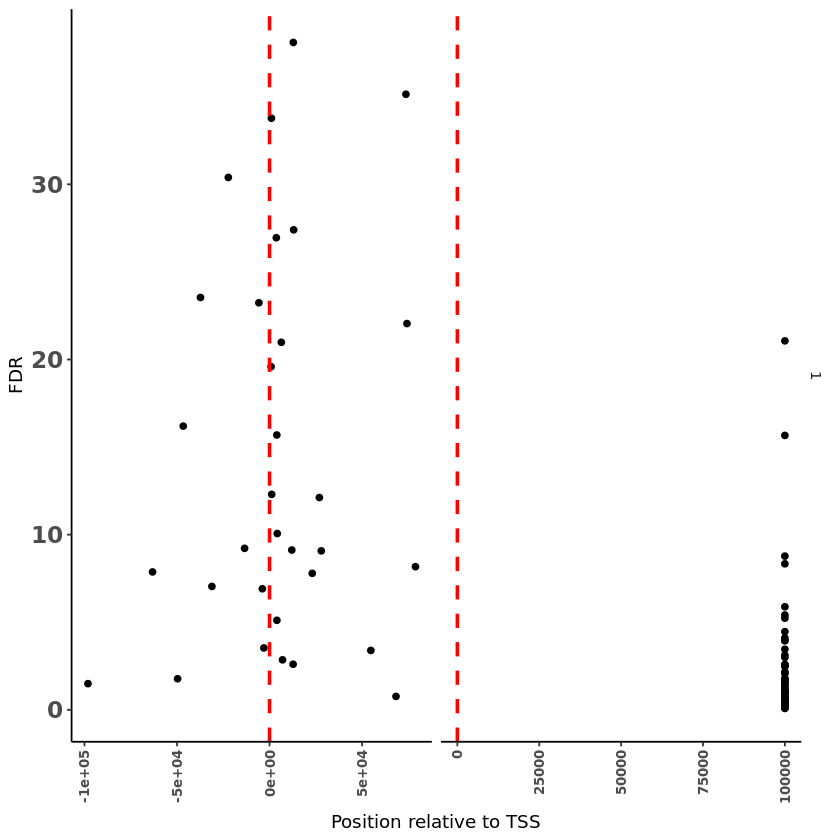

In [7]:
#Plot the plot 
final.assembled.df %>%
ggplot() +
geom_point(aes(x = position_difference, y = -log10(fdr))) +
facet_grid(1~cis_or_trans, scales='free_x') +
geom_vline(xintercept = 0, linetype = "dashed", color = "red", size = 1) +


theme_bw() +


theme(
axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)
) +

theme(
panel.border = element_blank(), 
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.text=element_text(size = 14, face = "bold"),
) +

theme(
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) +

theme(
axis.text.x = element_text(size = 8),
) +

theme(
  strip.background = element_blank(),
  strip.text.x = element_blank()
) +


xlab("Position relative to TSS") +
ylab("FDR") 

#Export it to the google bucket
setwd("/home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis")
ggsave("position_vs_pval.pdf", height = 4, width = 4)
system(glue::glue("
cd home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis
gsutil cp position_vs_pval.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

In [11]:
#Calculate how many are cis vs trans
num.cis = final.assembled.df %>%
filter(cis_or_trans %in% "cis") %>%
nrow()

num.trans = final.assembled.df %>%
filter(cis_or_trans %in% "trans") %>%
nrow()

num.cis
num.trans

[1] 32

[1] 66

In [12]:
#Calculate which SNPs are duplicated
duplicated.snps = final.assembled.df %>%
select(gene, snp_chr, snp_pos, snp_ref, snp_alt) %>%
mutate(snp = paste(snp_chr, ":", snp_pos, ":", snp_ref, ":", snp_alt, sep = "")) %>%
group_by(snp) %>%
filter(n() > 1)


head(duplicated.snps)



gene,snp_chr,snp_pos,snp_ref,snp_alt,snp
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
IFNE,chr9,21340131,A,G,chr9:21340131:A:G
IFNA16,chr9,21340131,A,G,chr9:21340131:A:G
IFNA6,chr9,21338127,A,C,chr9:21338127:A:C
IFNA14,chr9,21338127,A,C,chr9:21338127:A:C


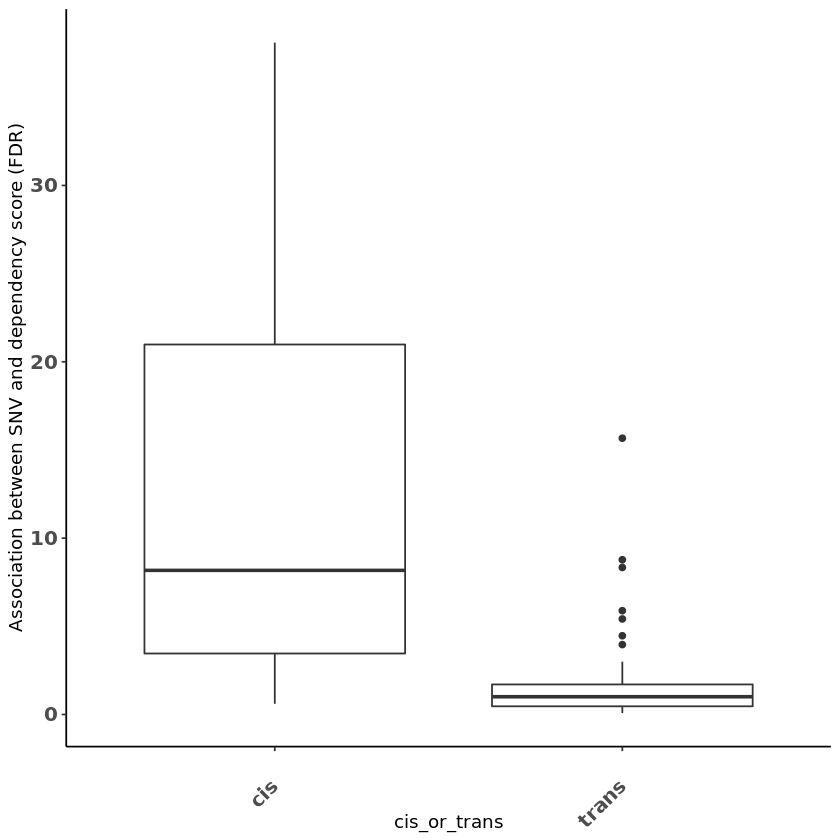

In [10]:
#Create a boxplot for cis vs trans
final.assembled.df %>%
ggplot() +
geom_boxplot(aes(x = cis_or_trans, y = -log10(fdr))) +
theme_bw() +

theme(
axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1)
) +

theme(
panel.border = element_blank(), 
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.text = element_text(size = 12, face = "bold"),
) +


theme(
axis.text.x = element_text(size = 12),
) +

theme(
strip.background = element_blank(),
strip.text.x = element_blank()
) +

ylab("Association between SNV and dependency score (FDR)")


#Export it to the google bucket
setwd("/home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis")
ggsave("boxplot_position_vs_pval.pdf", height = 3, width = 1.75)
system(glue::glue("
cd home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis
gsutil cp boxplot_position_vs_pval.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

In [13]:
head(final.assembled.df)

,gene,snp_chr,snp_pos,snp_ref,snp_alt,fdr,tss_chr,tss_pos,strand,cis_or_trans,position_difference
,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<int>,<chr>,<chr>,<dbl>
1,TUT1,chr11,62578659,C,T,7.962065e-39,chr11,62591523,-,cis,12864
2,ECD,chr10,73094386,A,G,7.230154e-36,chr10,73168095,-,cis,73709
3,MRTO4,chr1,19252818,GT,G,1.689572e-34,chr1,19251805,+,cis,1013
4,RPS5,chr19,58365001,A,G,4.034371e-31,chr19,58387269,+,cis,-22268
5,RESP18,chr2,219320135,G,A,3.977248e-28,chr2,219333177,-,cis,13042
6,SRP14,chr15,40035497,C,G,1.121033e-27,chr15,40039181,-,cis,3684


In [11]:
#calculate the total number of cis vs trans qTLs
total.cis = final.assembled.df %>% filter(cis_or_trans %in% "cis") %>% nrow
total.trans = final.assembled.df %>% filter(cis_or_trans %in% "trans") %>% nrow

total.cis
total.trans

[1] 41

[1] 57